## Imports

In [1]:
import os
import numpy as np
import random

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

2024-06-28 09:53:29.456983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 09:53:29.457083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 09:53:29.561099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set a seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data preprocessing

In [3]:
# Define the function to crop patches
def crop_patches(image, patch_size=(128, 128), stride=125):
    patches = []
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size

    for i in range(0, img_height - patch_height + 1, stride):
        for j in range(0, img_width - patch_width + 1, stride):
            patch = image[i:i + patch_height, j:j + patch_width]
            patches.append(patch)
    return patches

In [4]:
# List of German cities
german_cities = ['aachen', 'bielefeld', 'dortmund', 'duesseldorf', 'koeln', 'muenster']

# Base directories for the images and labels
image_base_dir = '/kaggle/input/global-land-cover-mapping-openearthmap/images'
label_base_dir = '/kaggle/input/global-land-cover-mapping-openearthmap/label'

In [5]:
#  List of German cities
german_cities = ['aachen', 'bielefeld', 'dortmund', 'duesseldorf', 'koeln', 'muenster']

# Base directories for the images and labels
base_dir = '/kaggle/input/global-land-cover-mapping-openearthmap'
image_base_dir = os.path.join(base_dir, 'images')
label_base_dir = os.path.join(base_dir, 'label')

# Function to read filenames from a text file
def read_filenames(txt_file):
    with open(txt_file, 'r') as file:
        filenames = file.read().splitlines()
    return filenames

# Function to process the images and labels and crop patches
def process_images(filenames, image_dir, label_dir):
    city_patches = {city: [] for city in german_cities}

    for filename in filenames:
        if filename.endswith('.tif'):
            city_name = filename.split('_')[0]
            if city_name in german_cities:
                image_path = os.path.join(image_dir, filename)
                label_path = os.path.join(label_dir, filename)

                image = np.array(Image.open(image_path))
                label = np.array(Image.open(label_path))

                # Ensure the image size is (1000, 1000, 3)
                assert image.shape == (1000, 1000, 3), f"Image {filename} has incorrect shape {image.shape}"
                assert label.shape == (1000, 1000), f"Label {filename} has incorrect shape {label.shape}"

                # Crop patches and store them
                image_patches = crop_patches(image)
                label_patches = crop_patches(label)

                for img_patch, lbl_patch in zip(image_patches, label_patches):
                    city_patches[city_name].append((img_patch, lbl_patch))

    return city_patches


In [6]:
# Read filenames from text files
train_filenames = read_filenames(os.path.join(base_dir, 'train.txt'))
val_filenames = read_filenames(os.path.join(base_dir, 'val.txt'))
test_filenames = read_filenames(os.path.join(base_dir, 'test.txt'))

# Process train and validation directories
train_patches = process_images(train_filenames, os.path.join(image_base_dir, 'train'), os.path.join(label_base_dir, 'train'))
val_patches = process_images(val_filenames, os.path.join(image_base_dir, 'val'), os.path.join(label_base_dir, 'val'))

# Print the number of patches for each city
for city, patches in train_patches.items():
    print(f"Train - City: {city}, Number of patches: {len(patches)}")
for city, patches in val_patches.items():
    print(f"Validation - City: {city}, Number of patches: {len(patches)}")

Train - City: aachen, Number of patches: 2058
Train - City: bielefeld, Number of patches: 2058
Train - City: dortmund, Number of patches: 2058
Train - City: duesseldorf, Number of patches: 2058
Train - City: koeln, Number of patches: 2058
Train - City: muenster, Number of patches: 2058
Validation - City: aachen, Number of patches: 343
Validation - City: bielefeld, Number of patches: 343
Validation - City: dortmund, Number of patches: 343
Validation - City: duesseldorf, Number of patches: 343
Validation - City: koeln, Number of patches: 343
Validation - City: muenster, Number of patches: 343


### Visualize image label pairs

In [7]:
# Function to print unique labels in all patches
def print_unique_labels(patches):
    unique_labels_set = set()
    for city, patch_list in patches.items():
        for i, (image_patch, label_patch) in enumerate(patch_list):
            unique_labels = np.unique(label_patch)
            unique_labels_set.update(unique_labels)
#             print(f"City: {city}, Patch {i+1}: Unique Labels: {unique_labels}")

    print("\nOverall Unique Labels in All Patches:")
    print(sorted(unique_labels_set))
    

# Print unique labels for all train patches
print_unique_labels(train_patches)



Overall Unique Labels in All Patches:
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [8]:
# Define the new class mapping
new_class_mapping = {
    0: 0,   # background
    8: 1,   # buildings
    3: 1,   # developed areas
    4: 1,   # roads
    1: 2,   # agriland
    5: 2,   # trees
    7: 2,   # vegetation
    2: 3,   # barren
    6: 4    # water
}

# Function to remap labels
def remap_labels(label, mapping):
    remapped_label = np.copy(label)
    for old_class, new_class in mapping.items():
        remapped_label[label == old_class] = new_class
    return remapped_label

# Apply the remapping to the dataset
def remap_dataset(patches, mapping):
    remapped_patches = {}
    for city, patch_list in patches.items():
        remapped_patch_list = []
        for image_patch, label_patch in patch_list:
            remapped_label_patch = remap_labels(label_patch, mapping)
            remapped_patch_list.append((image_patch, remapped_label_patch))
        remapped_patches[city] = remapped_patch_list
    return remapped_patches

# Remap the train and validation patches
train_patches = remap_dataset(train_patches, new_class_mapping)
val_patches = remap_dataset(val_patches, new_class_mapping)

In [9]:
print_unique_labels(train_patches)


Overall Unique Labels in All Patches:
[0, 1, 2, 3, 4]


(128, 128, 3) (128, 128) [1 2 3]
(128, 128, 3) (128, 128) [1 2 3]
(128, 128, 3) (128, 128) [1 2 3]
(128, 128, 3) (128, 128) [1 2 3]
(128, 128, 3) (128, 128) [1 2 3]


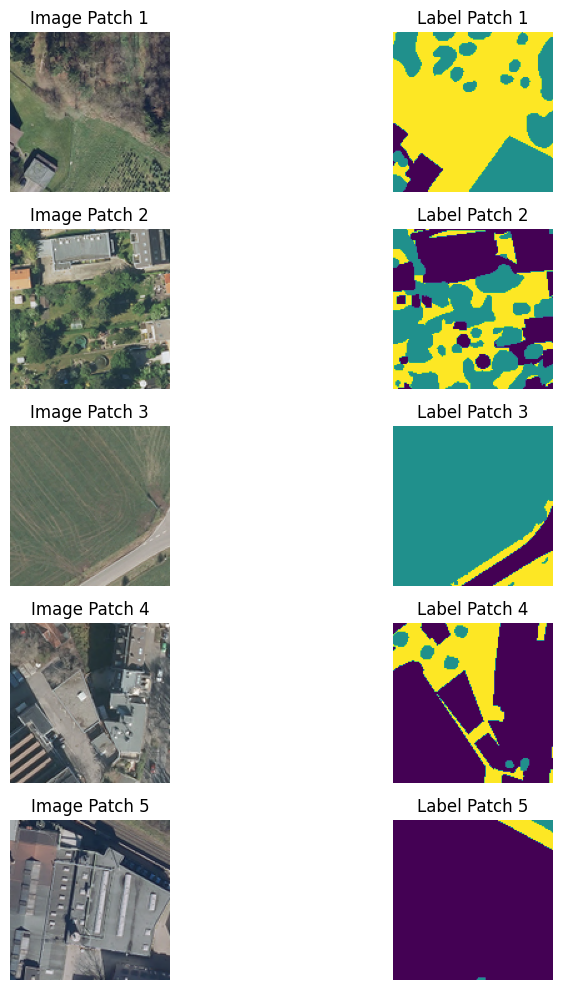

In [10]:
# Collect all patches in a list
all_train_patches = []
for city, patches in train_patches.items():
    all_train_patches.extend(patches)

# Select 5 random patches
random_patches = random.sample(all_train_patches, 5)

# Plot the 5 random image-label pairs
plt.figure(figsize=(10, 10))
for i, (image_patch, label_patch) in enumerate(random_patches):
    print(image_patch.shape, label_patch.shape, np.unique(label_patch))
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image_patch)
    plt.title(f'Image Patch {i+1}')
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(label_patch)
    plt.title(f'Label Patch {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

(128, 128, 3) (128, 128)
(128, 128, 3) (128, 128)
(128, 128, 3) (128, 128)


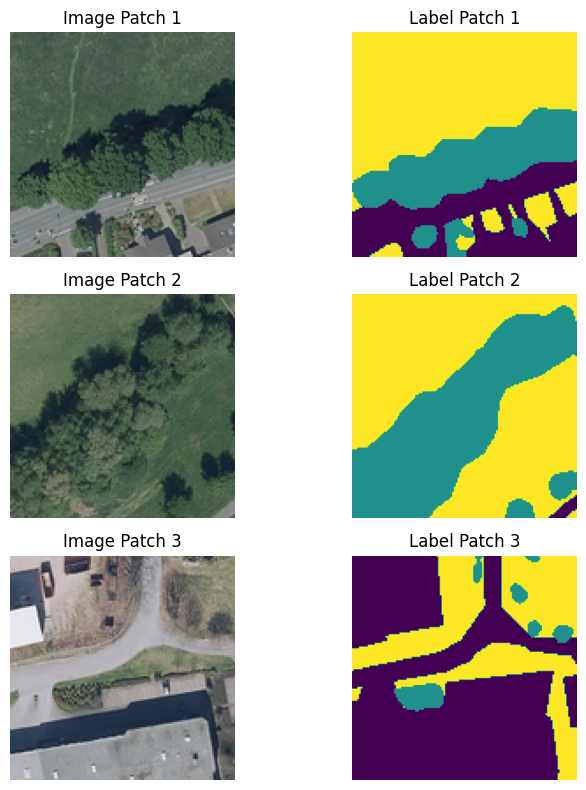

In [11]:
# Collect all patches in a list
all_val_patches = []
for city, patches in val_patches.items():
    all_val_patches.extend(patches)

# Select 3 random patches
random_patches = random.sample(all_val_patches, 3)

# Plot the 3 random image-label pairs
plt.figure(figsize=(8, 8))
for i, (image_patch, label_patch) in enumerate(random_patches):
    print(image_patch.shape, label_patch.shape)
    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(image_patch)
    plt.title(f'Image Patch {i+1}')
    plt.axis('off')

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(label_patch)
    plt.title(f'Label Patch {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Define the mean IoU metric
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

## Segmentation Modelling

### Model creation

In [13]:
# Define input shape
input_shape = (128, 128, 3)

# Define the number of classes
num_classes = 5

In [14]:
# Function to extract patches and labels from the given dictionary
def extract_patches(patches_dict):
    images, labels = [], []
    for city, patches in patches_dict.items():
        for image_patch, label_patch in patches:
            images.append(image_patch)
            labels.append(label_patch)
    return np.array(images), np.array(labels)

# Extract training and validation data
X_train, y_train = extract_patches(train_patches)
X_val, y_val = extract_patches(val_patches)

# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

In [15]:
# Ensure X_train and y_train have the same number of elements
assert len(X_train) == len(y_train), "X_train and y_train must have the same number of elements"

# Create a list of indices and shuffle it
indices = list(range(len(X_train)))
random.shuffle(indices)

# Select the first 2500 shuffled indices
selected_indices = indices[:2500]

# Use the selected indices to get the corresponding elements from X_train and y_train
X_train = X_train[selected_indices]
y_train = y_train[selected_indices]

# Check the shapes
print(X_train.shape, y_train.shape)


(2500, 128, 128, 3) (2500, 128, 128, 5)


In [16]:
# X_train, y_train = X_train[:2500], y_train[:2500]
# X_train.shape, y_train.shape

In [17]:
X_val.shape, y_val.shape

((2058, 128, 128, 3), (2058, 128, 128, 5))

In [18]:
# Function to create the smaller model
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Create the model
model = create_model(input_shape, num_classes)

In [19]:
# Display the model summaries
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_2[0]

 Total params: 969,413 (3.70 MB)

 Trainable params: 969,413 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define callbacks
callbacks = [
#     EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
#     ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)
]

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[MeanIoU(num_classes=num_classes)])

In [22]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50


2024-06-28 09:54:23.253637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-06-28 09:54:23.253730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-06-28 09:54:23.253740: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-06-28 09:54:23.253751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-06-28 09:54:23.253790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-06-28 09:54:23.253823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-06-28 09:54:23.253904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-06-28 09:54:23.253917: E exte

 3/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 101.6777 - mean_io_u: 0.1185 

I0000 00:00:1719568474.854124      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 87.8182 - mean_io_u: 0.1205

2024-06-28 09:54:38.452848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98304: 4.2055, expected 3.46583
2024-06-28 09:54:38.452904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98308: 5.0598, expected 4.32013
2024-06-28 09:54:38.452914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98309: 5.15094, expected 4.41127
2024-06-28 09:54:38.452922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98310: 5.6654, expected 4.92573
2024-06-28 09:54:38.452929: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98311: 4.73688, expected 3.9972
2024-06-28 09:54:38.452937: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98312: 4.39242, expected 3.65274
2024-06-28 09:54:38.452945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98313: 4.40308, expected 3.6634
2024-06-28 09:54:38.452953: E ex

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 87.6516 - mean_io_u: 0.1206

2024-06-28 09:54:47.945942: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.85448, expected 4.07175
2024-06-28 09:54:47.946004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.36081, expected 5.57808
2024-06-28 09:54:47.946013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.46444, expected 5.68171
2024-06-28 09:54:47.946021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.06415, expected 4.28142
2024-06-28 09:54:47.946046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.26328, expected 4.48055
2024-06-28 09:54:47.946054: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.23331, expected 4.45058
2024-06-28 09:54:47.946062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.24958, expected 3.46685
2024-06-28 09:54:47.946070: E external/local_xla/xla/se

79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 194ms/step - loss: 87.5986 - mean_io_u: 0.1206 - val_loss: 72.0390 - val_mean_io_u: 0.1061
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 45.2005 - mean_io_u: 0.1312 - val_loss: 144.5890 - val_mean_io_u: 0.0922
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4139.7515 - mean_io_u: 0.1152 - val_loss: 428.2745 - val_mean_io_u: 0.0956
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2857.6360 - mean_io_u: 0.1155 - val_loss: 12754.4102 - val_mean_io_u: 0.0852
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 20301.2207 - mean_io_u: 0.1036 - val_loss: 9713.6982 - val_mean_io_u: 0.0950
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4271.6787 - mean_io_u: 0.1069 - val_loss: 18610.3984 - val_mean_io_u: 0.1071
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 12988.8018 - mean_io_u: 0.1289 - val_loss: 19215.3887 - val_mean_io_u: 0.0892
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 19155.17

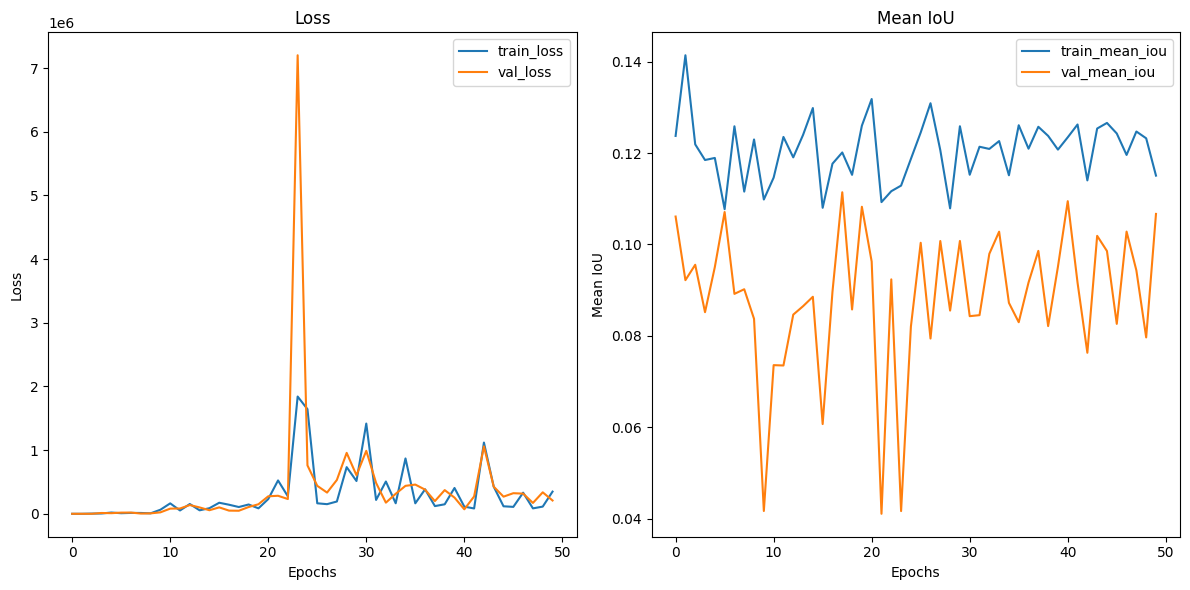

In [23]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_io_u'], label='train_mean_iou')
    plt.plot(history.history['val_mean_io_u'], label='val_mean_iou')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.title('Mean IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


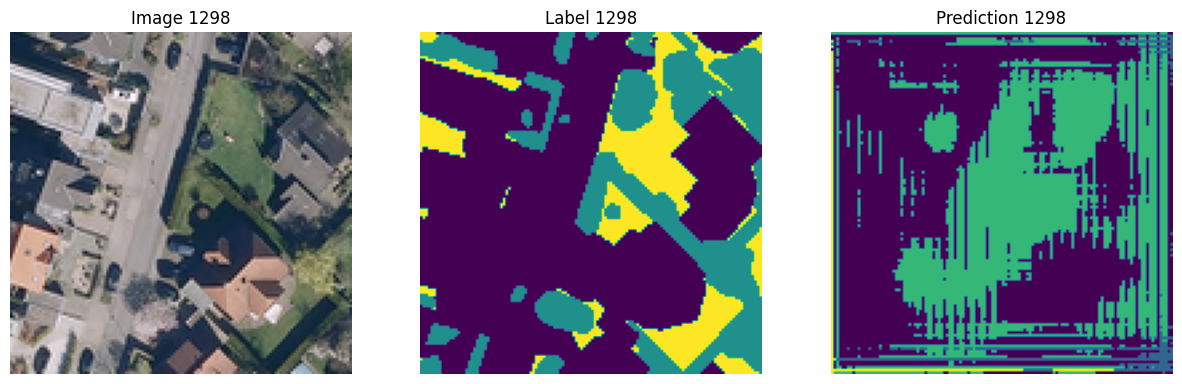

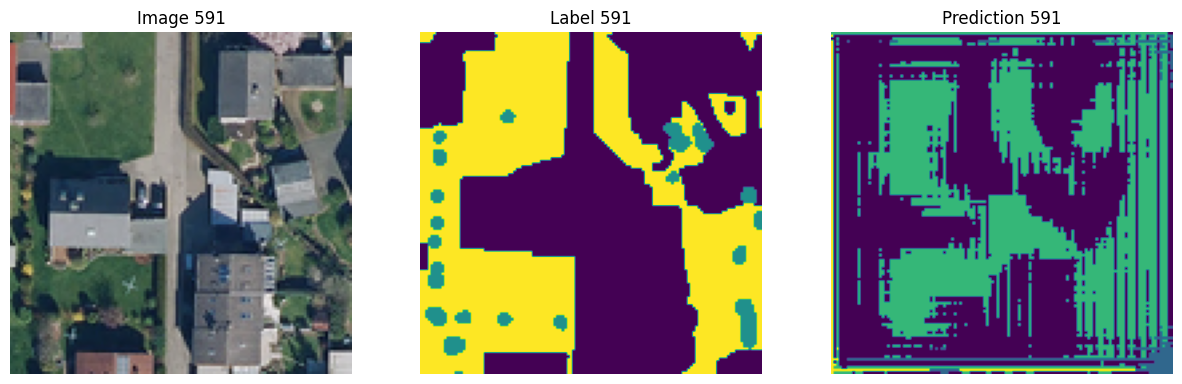

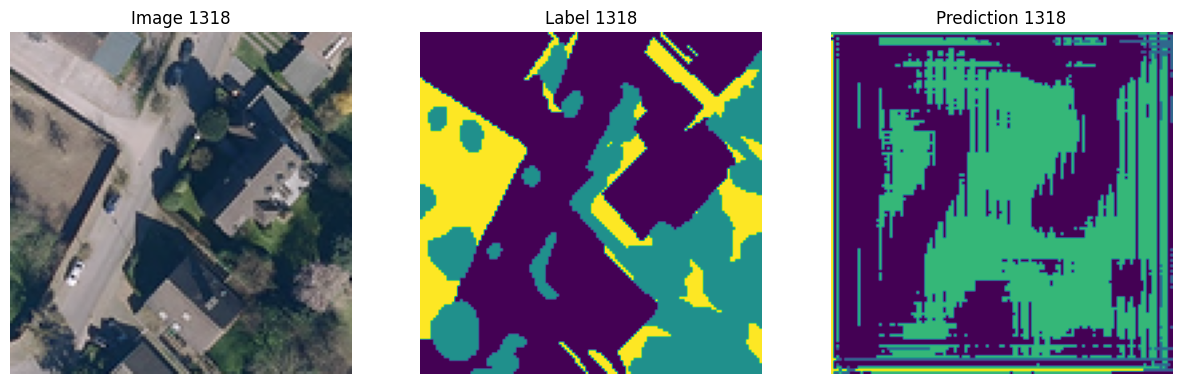

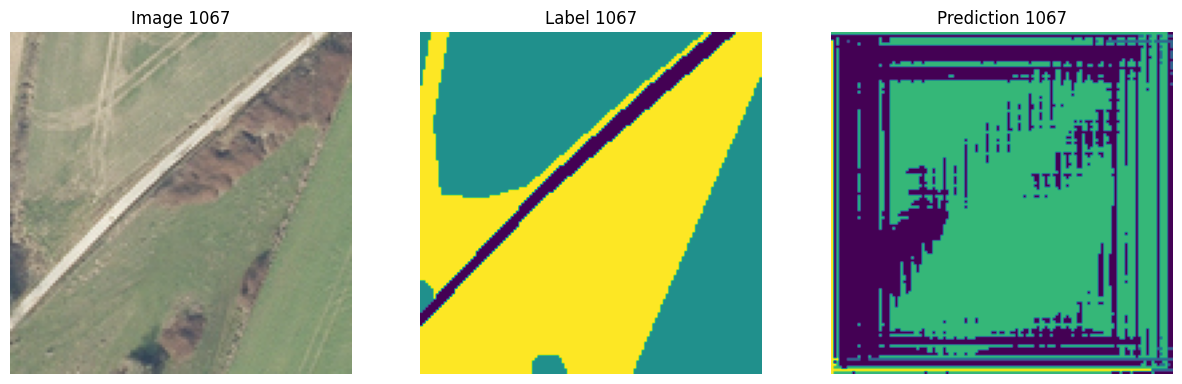

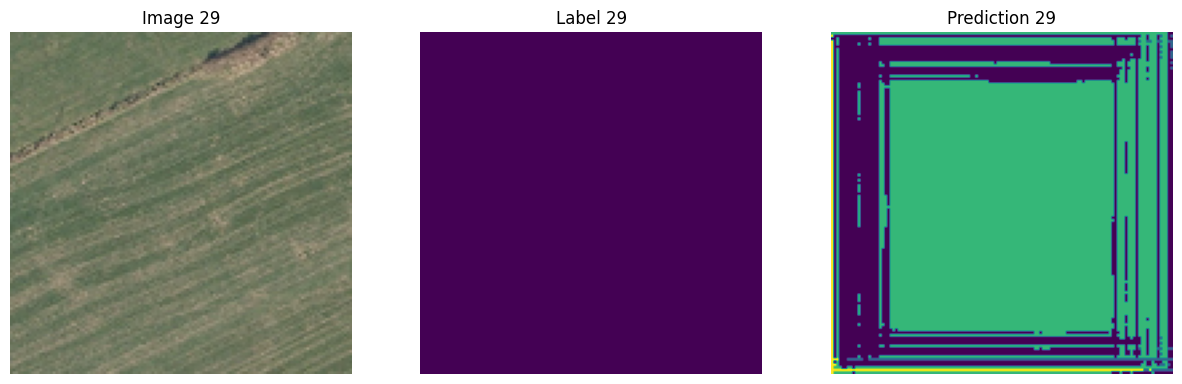

In [24]:
# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Function to plot image, label, and prediction
def plot_image_label_prediction(image, label, prediction, index):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Image {index}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(label, axis=-1))
    plt.title(f'Label {index}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(prediction, axis=-1))
    plt.title(f'Prediction {index}')
    plt.axis('off')
    
    plt.show()

# Select 3 random indices from the validation set
indices = np.random.choice(len(X_val), 5, replace=False)

# Plot the image-label-prediction triads
for i, index in enumerate(indices):
    plot_image_label_prediction(X_val[index], y_val[index], val_predictions[index], index)

In [25]:
# Function to calculate IoU for each class
def calculate_iou_per_class(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        if union == 0:
            iou = 0.0
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

In [26]:
# Generate predictions for validation patches
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=-1)  # Convert from one-hot to class indices

# Calculate IoU for each class
num_classes = 5  # Assuming the new number of classes is 6
ious = calculate_iou_per_class(np.argmax(y_val, axis=-1), y_pred, num_classes)

# Print the IoU for each class
for cls, iou in enumerate(ious):
    print(f"Class {cls}: IoU = {iou:.4f}")

# Print classification report
# print(classification_report(y_val.flatten(), y_pred.flatten()))

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: IoU = 0.0000
Class 1: IoU = 0.3440
Class 2: IoU = 0.0137
Class 3: IoU = 0.1750
Class 4: IoU = 0.0008


In [27]:
# Filter test filenames for German cities
german_test_filenames = [filename for filename in test_filenames if filename.split('_')[0] in german_cities]

# Select a random test file
random_test_file = random.choice(german_test_filenames)
test_image_path = os.path.join(image_base_dir, 'test', random_test_file)

# Load and process the test image
test_image = np.array(Image.open(test_image_path))

test_image.shape

(1000, 1000, 3)

2024-06-28 09:58:30.008943: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.73934, expected 3.23023
2024-06-28 09:58:30.009001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.62197, expected 3.11286
2024-06-28 09:58:30.009011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.87954, expected 3.37043
2024-06-28 09:58:30.009018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.47842, expected 2.96931
2024-06-28 09:58:30.009026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.88297, expected 3.37386
2024-06-28 09:58:30.009034: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.63122, expected 3.12211
2024-06-28 09:58:30.009041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43: 3.30186, expected 2.79275
2024-06-28 09:58:30.009049: E external/local_xla/xla/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

/tmp/ipykernel_34/766947980.py:28: RuntimeWarning: invalid value encountered in divide
  reconstructed_image /= count_matrix


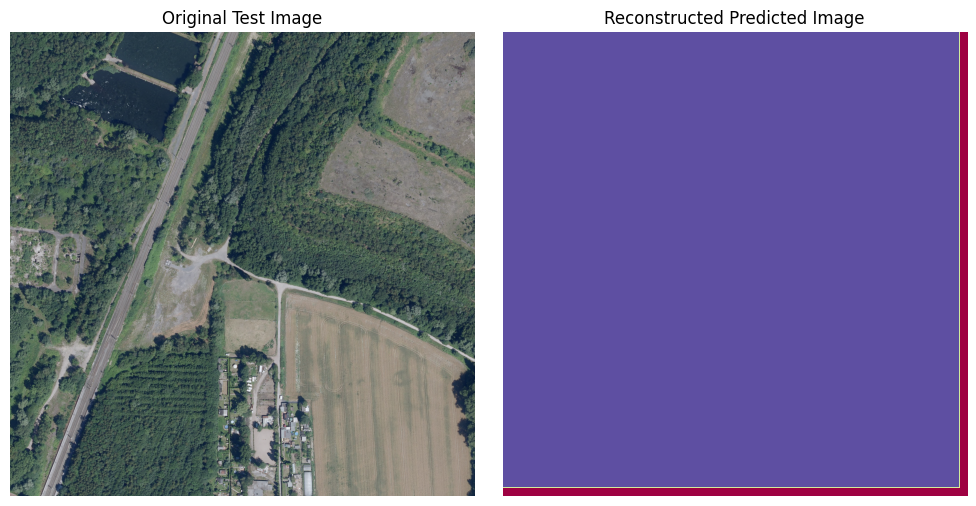

In [28]:
# Function to read filenames from a text file
def read_filenames(txt_file):
    with open(txt_file, 'r') as file:
        filenames = file.read().splitlines()
    return filenames

# Function to crop patches from an image
def crop_patches(image, patch_size=128, stride=128):
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

# Function to reconstruct the full image from patches
def reconstruct_image(patches, image_shape, patch_size=128, stride=128):
    reconstructed_image = np.zeros(image_shape)
    count_matrix = np.zeros(image_shape)

    patch_index = 0
    for i in range(0, image_shape[0] - patch_size + 1, stride):
        for j in range(0, image_shape[1] - patch_size + 1, stride):
            reconstructed_image[i:i+patch_size, j:j+patch_size] += patches[patch_index]
            count_matrix[i:i+patch_size, j:j+patch_size] += 1
            patch_index += 1

    reconstructed_image /= count_matrix
    return reconstructed_image


# Crop patches from the test image
test_patches = crop_patches(test_image, patch_size=128, stride=122)

# Generate predictions for each patch
predicted_patches = []
for patch in test_patches:
    patch = np.expand_dims(patch, axis=0)  # Add batch dimension
    predicted_patch = model.predict(patch)
    predicted_patch = np.squeeze(predicted_patch)  # Remove batch dimension
    predicted_patches.append(predicted_patch)

# Reconstruct the full predicted image from patches
predicted_image = reconstruct_image(predicted_patches, 
                image_shape=(test_image.shape[0],test_image.shape[1],predicted_patches[0].shape[2]),
                patch_size=128, stride=122)

# Plot the original test image and the reconstructed predicted label image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.argmax(predicted_image, axis=-1),cmap="Spectral")
plt.title('Reconstructed Predicted Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
model.save('/kaggle/working/imperviousness.h5')